In [2]:
import pandas as pd 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x).rstrip('0').rstrip('.') if x != 0 else '0')
import numpy as np 
np.set_printoptions(suppress=True, precision=6)
import polars as pl 
pl.Config(set_fmt_float="full")
pl.Config(tbl_cols=1000)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
import seaborn as sns
np.random.seed(22)
import torch 
from packages.utils2 import Optimize
from packages.utils2 import SaveParameters, LoadParameters
from packages.utils2 import prepare_data_level0_mono, prepare_data_level1_mono, prepare_data_level2_mono

device = 'cpu'

In [3]:
# initiate your year of study :
year=2015

# load your data : 
data = pl.read_parquet("/Users/selimdridi/Downloads/2015-2/single_actives_2015.parquet")


# drop intrazonal observations:
data = data.filter(pl.col('INTRAZONAL')==0)

# normalized weights:
data = data.with_columns(
    WEIGHT=(pl.col('IPONDI') * len(data)/pl.col('IPONDI').sum())
    )

# transform to pandas for the optimization step:
df = data.to_pandas()

# level 0

### if the year of study is after 2016 (not included)

### if the year of study is before 2016 (included)

In [4]:
def level0(params, 
           df,
           pytorch=False, 
           null_loglik=False, 
           grad=False, 
           logsum=False,
           df_length=False,
           all_sample=False):
    
    v = df['vars']

    if all_sample:
        idx = df['all_idx']
    else:
        idx = df['idx']

    def var(name): return v[name]

    if grad:
        params = params.clone().requires_grad_(True)
    else:
        params = torch.tensor(params, dtype=torch.float64)
        
    (
        sigma_l0, 
        ASC_2R_l0, ASC_TC_l0,

        B_DIST_2R2_l0, 
        B_DIST_WALK2_l0,
        B_TT_TC2_l0,
        delta_TT_TC_l0,
        delta_DIST_2R_l0,  


    ) = params

    XB_TC = (torch.tensor(0))

    XB_2R = (torch.tensor(0))

    V_TC = (ASC_TC_l0 + XB_TC
            - torch.exp(delta_TT_TC_l0) * torch.min(var('TT_TC'), torch.tensor((180/60))) 
            + B_TT_TC2_l0 * (torch.min(var('TT_TC'), torch.tensor((180/60)))**2))
    
    V_WALK = (-3 * torch.min(var('DISTANCE'), torch.tensor(10)) 
              + B_DIST_WALK2_l0 * (torch.min(var('DISTANCE'), torch.tensor(10))**2) 
              ) 
        
    V_2R = (ASC_2R_l0 + XB_2R
              - torch.exp(delta_DIST_2R_l0) * torch.min(var('DISTANCE'), torch.tensor(25))
              + B_DIST_2R2_l0 * (torch.min(var('DISTANCE'), torch.tensor(25))**2)
              )
    

    # --------------- Probabilities
    # https://stats.stackexchange.com/questions/304758/softmax-overflow
    V_stack = torch.stack([V_TC[idx] / sigma_l0, 
                            V_WALK[idx] / sigma_l0, 
                            V_2R[idx] / sigma_l0], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_TC, P_WALK, P_2R = exp_V.T / sum_exp

    # --------------- Choices

    choices = df['df']
    
    Choice_TC = torch.tensor((choices['COMMUTE_MODE']=='PUBLIC').astype(int).values, dtype=torch.float64)
    Choice_WALK = torch.tensor((choices['COMMUTE_MODE']=='WALK').astype(int).values, dtype=torch.float64)
    Choice_2R = torch.tensor((choices['COMMUTE_MODE']=='TWO_WHEELS').astype(int).values, dtype=torch.float64)

    weights = var('WEIGHT')
    weights = weights[idx]

    if null_loglik:

        null_LL = torch.sum(weights * Choice_TC[idx] * torch.log(torch.sum(Choice_TC[idx])/len(idx))) + \
            torch.sum(weights * Choice_2R[idx] * torch.log(torch.sum(Choice_2R[idx])/len(idx))) + \
            torch.sum(weights * Choice_WALK[idx] * torch.log(torch.sum(Choice_WALK[idx])/len(idx)))
        return -null_LL

    epsilon = 1e-30  


    LL = torch.sum(weights * Choice_TC[idx] * torch.log(torch.clamp(P_TC, min=epsilon))) + \
        torch.sum(weights * Choice_2R[idx] * torch.log(torch.clamp(P_2R, min=epsilon))) + \
        torch.sum(weights * Choice_WALK[idx] * torch.log(torch.clamp(P_WALK, min=epsilon)))

    if pytorch:
        return -LL
        
    if logsum:
        LS = sigma_l0 * torch.log(
            torch.exp(V_TC / sigma_l0) 
            + torch.exp(V_WALK / sigma_l0) 
            + torch.exp(V_2R / sigma_l0) 
        )
        return LS
    
    if df_length:
        return len(idx)
        
    return (-LL).detach().numpy()

In [5]:
summary_level0, parameters_level0 = Optimize(level0, 
         prepare_data_level0_mono(df, year=year), 
        # initial_values='Level0_CONSTRAINT_mono',
         max_iter=5000,
         gtol=1,
         display_results=True)

Optimizing:   4%|▍         | 216/5000 [00:27<09:54,  8.05it/s, Objective Value=39840.32556]

Convergence: True


Optimizing:   4%|▍         | 216/5000 [00:28<10:23,  7.68it/s, Objective Value=39840.32556]


In [6]:
SaveParameters(level0,
               parameters_level0,
               excel=True, 
               data=prepare_data_level0_mono(df, year=year),
               file_name='Level0_CONSTRAINT_celib')

ModuleNotFoundError: No module named 'openpyxl'

In [7]:
import os
import polars as pl

# Choix du bon chemin selon l'utilisateur
path = os.getcwd()
if path.startswith('/home'):
    base_path = '/home/youssef/LUTIYoussef'
else:
    base_path = '/Users/selimdridi/Downloads'

# Année d'étude
year = 2015

# Chargement du fichier
file_path = os.path.join(base_path, str(year), f'monoactives_{year}.parquet')
print("➡️ Chemin du fichier :", file_path)

# Lecture
data = pl.read_parquet(file_path)

# Traitement
data = data.filter(pl.col('INTRAZONAL') == 0)
data = data.with_columns(
    WEIGHT=(pl.col('IPONDI') * len(data) / pl.col('IPONDI').sum())
)
df = data.to_pandas()

➡️ Chemin du fichier : /Users/selimdridi/Downloads/2015/monoactives_2015.parquet


In [8]:
# 1 pour homme, 0 pour femme
df['GENDER'] = (df['SEXE'] == 1).astype(int)
df_level0 = df[['SEXE', 'GENDER', 'TRANS', 'VOIT', 'AGED', 'DIPL', 'CS1', 'TP', 'IPONDI']]
print(df_level0.head(20))

    SEXE  GENDER  TRANS  VOIT  AGED DIPL  CS1  TP  IPONDI
0      1       1      5     1    27    C    5   1   3.066
1      2       0      5     1    24    D    6   1   1.109
2      1       1      5     1    60    D    3   1   3.066
3      1       1      5     0    25    B    6   1   1.109
4      2       0      5     1    28    D    3   1   1.109
5      1       1      5     1    63    D    2   2   0.929
6      1       1      5     1    34    B    6   1   2.473
7      1       1      5     1    47    C    5   1   2.473
8      2       0      5     1    36    D    5   2   1.109
9      1       1      5     0    50    B    6   2   2.963
10     2       0      5     1    55    B    5   1   2.682
11     1       1      5     0    28    A    6   2   2.682
12     2       0      5     1    34    D    3   1   3.006
13     2       0      5     2    59    A    5   1   2.772
14     1       1      5     1    57    A    6   1    2.79
15     2       0      5     0    33    D    5   1   0.929
16     2      

In [9]:
print(df.columns)
# Sexe binaire (si pas déjà fait)
df['GENDER'] = (df['SEXE'] == 1).astype(int)  # 1 = homme, 0 = femme

# Possession de voiture (niveau 1 ou 2)
df['HAS_CAR'] = (df['VOIT'] >= 1).astype(int)
df['NO_CAR'] = (df['VOIT'] == 0).astype(int)

# Dummies géographiques
df['RES_OUTER'] = df['RES_OUTERRING']
df['RES_INNER'] = df['RES_INNERRING']
df['RES_PARIS'] = df['RES_PARIS']

# Type d'emploi
df['IS_WHITE_COLLAR'] = df['OCCP_WHITE_COLLAR']
df['IS_BLUE_COLLAR'] = df['OCCP_BLUE_COLLAR']
df['IS_EMPLOYEE'] = df['OCCP_EMPLOYEE']

# Âge en tranches (si besoin plus tard)
df['AGE_18_30'] = (df['AGED'] <= 30).astype(int)
df['AGE_31_50'] = ((df['AGED'] > 30) & (df['AGED'] <= 50)).astype(int)
df['AGE_51_plus'] = (df['AGED'] > 50).astype(int)


Index(['ID', 'AGED', 'COUPLE', 'CS1', 'DIPL', 'DNAI', 'EMPL', 'ETUD', 'ILETUD',
       'ILT', 'IMMI', 'INAI', 'INATC', 'IPONDI', 'LPRM', 'MOCO', 'MODV',
       'NA17', 'NA5', 'NAIDT', 'ORIDT', 'SEXE', 'STAT_CONJ', 'STATR', 'TACT',
       'TP', 'TRANS', 'DCLT', 'OCCP_SELF_EMPLOYED', 'OCCP_BLUE_COLLAR',
       'OCCP_WHITE_COLLAR', 'OCCP_PROFESSIONAL', 'OCCP_EMPLOYEE',
       'WP_INNERRING', 'WP_OUTERRING', 'WP_PARIS', 'TT_VP', 'TT_TC',
       'FREEFLOW_TT', 'DISTANCE', 'COMMUTE_MODE', 'FULL_TIME', 'FOREIGN',
       'COMMUNE', 'IRIS', 'CATIRIS', 'CATL', 'CATPC', 'DEPT', 'DEROU', 'GARL',
       'HLML', 'INPER', 'METRODOM', 'NBPI', 'NPERR', 'SFM', 'SURF', 'TRIRIS',
       'TYPL', 'TYPMC', 'TYPMR', 'VOIT', 'NENF', 'CHILDREN_0_3',
       'CHILDREN_4_6', 'CHILDREN_7_11', 'CHILDREN_6_11', 'CHILDREN_12_16',
       'CHILDREN_17_plus', 'CHILDREN_0_16', 'CHILDREN_0_5', 'RES_INNERRING',
       'RES_OUTERRING', 'RES_PARIS', 'HOMEOWNERSHIP', 'INTRAZONAL', 'WEIGHT',
       'GENDER'],
      dtype='objec

In [10]:
def level0(params, 
           df,
           pytorch=False, 
           null_loglik=False, 
           grad=False, 
           logsum=False,
           df_length=False,
           all_sample=False):
    
    v = df['vars']

    if all_sample:
        idx = df['all_idx']
    else:
        idx = df['idx']

    def var(name): return v[name]

    if grad:
        params = params.clone().requires_grad_(True)
    else:
        params = torch.tensor(params, dtype=torch.float64)
        
    (
        sigma_l0, 
        ASC_2R_l0, ASC_TC_l0,

        B_DIST_2R2_l0, 
        B_DIST_WALK2_l0,
        B_TT_TC2_l0,

        B_GENDER_TC_l0,
        B_GENDER_2R_l0,

        B_OCCP_SELF_EMPLOYED_TC_l0,
        B_OCCP_SELF_EMPLOYED_2R_l0,
        B_OCCP_BLUE_COLLAR_TC_l0,
        B_OCCP_BLUE_COLLAR_2R_l0,
        B_OCCP_WHITE_COLLAR_TC_l0,
        B_OCCP_WHITE_COLLAR_2R_l0,
        B_OCCP_PROFESSIONAL_TC_l0,
        B_OCCP_PROFESSIONAL_2R_l0,

        B_RES_INNERRING_TC_l0,
        B_RES_INNERRING_2R_l0,
        B_RES_OUTERRING_TC_l0,
        B_RES_OUTERRING_2R_l0,

        B_WP_INNERRING_TC_l0,
        B_WP_INNERRING_2R_l0,
        B_WP_OUTERRING_TC_l0,
        B_WP_OUTERRING_2R_l0,
        
        B_AGE40_TC_l0,
        B_AGE40_TC2_l0,
        B_AGE40_2R_l0,
        B_AGE40_2R2_l0,

        B_ETUD_TC_l0,
        B_ETUD_2R_l0,

        B_HOMEOWNERSHIP_TC_l0,
        B_HOMEOWNERSHIP_2R_l0,
        
        delta_TT_TC_l0,
        delta_DIST_2R_l0,  


    ) = params

    XB_TC = B_GENDER_TC_l0*var('GENDER') + \
        B_OCCP_SELF_EMPLOYED_TC_l0*var('OCCP_SELF_EMPLOYED') + B_OCCP_BLUE_COLLAR_TC_l0*var('OCCP_BLUE_COLLAR') + \
        B_OCCP_WHITE_COLLAR_TC_l0*var('OCCP_WHITE_COLLAR') + B_OCCP_PROFESSIONAL_TC_l0*var('OCCP_PROFESSIONAL') + \
        B_RES_INNERRING_TC_l0*var('RES_INNERRING') + B_RES_OUTERRING_TC_l0*var('RES_OUTERRING') + \
        B_WP_INNERRING_TC_l0*var('WP_INNERRING') + B_WP_OUTERRING_TC_l0*var('WP_OUTERRING') +\
        B_AGE40_TC_l0 * ((var('AGED')-40)/10) + B_AGE40_TC2_l0 * (((var('AGED')-40)/10)**2) +\
        B_ETUD_TC_l0 * var('ETUD') +\
        B_HOMEOWNERSHIP_TC_l0 * var('HOMEOWNERSHIP')

    XB_2R = B_GENDER_2R_l0*var('GENDER') + \
        B_OCCP_SELF_EMPLOYED_2R_l0*var('OCCP_SELF_EMPLOYED') + B_OCCP_BLUE_COLLAR_2R_l0*var('OCCP_BLUE_COLLAR') + \
        B_OCCP_WHITE_COLLAR_2R_l0*var('OCCP_WHITE_COLLAR') + B_OCCP_PROFESSIONAL_2R_l0*var('OCCP_PROFESSIONAL') + \
        B_RES_INNERRING_2R_l0*var('RES_INNERRING') + B_RES_OUTERRING_2R_l0*var('RES_OUTERRING') + \
        B_WP_INNERRING_2R_l0*var('WP_INNERRING') + B_WP_OUTERRING_2R_l0*var('WP_OUTERRING') +\
        B_AGE40_2R_l0 * ((var('AGED')-40)/10) + B_AGE40_2R2_l0 * (((var('AGED')-40)/10)**2) +\
        B_ETUD_2R_l0 * var('ETUD') +\
        B_HOMEOWNERSHIP_2R_l0 * var('HOMEOWNERSHIP')
        

    V_TC = (ASC_TC_l0 + XB_TC
            - torch.exp(delta_TT_TC_l0) * torch.min(var('TT_TC'), torch.tensor((180/60))) 
            + B_TT_TC2_l0 * (torch.min(var('TT_TC'), torch.tensor((180/60)))**2))
    
    V_WALK = (-3 * torch.min(var('DISTANCE'), torch.tensor(10)) 
              + B_DIST_WALK2_l0 * (torch.min(var('DISTANCE'), torch.tensor(10))**2) 
              ) 
        
    V_2R = (ASC_2R_l0 + XB_2R
              - torch.exp(delta_DIST_2R_l0) * torch.min(var('DISTANCE'), torch.tensor(25))
              + B_DIST_2R2_l0 * (torch.min(var('DISTANCE'), torch.tensor(25))**2)
              )
    

    # --------------- Probabilities
    # https://stats.stackexchange.com/questions/304758/softmax-overflow
    V_stack = torch.stack([V_TC[idx] / sigma_l0, 
                            V_WALK[idx] / sigma_l0, 
                            V_2R[idx] / sigma_l0], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_TC, P_WALK, P_2R = exp_V.T / sum_exp

    # --------------- Choices

    choices = df['df']
    
    Choice_TC = torch.tensor((choices['COMMUTE_MODE']=='PUBLIC').astype(int).values, dtype=torch.float64)
    Choice_WALK = torch.tensor((choices['COMMUTE_MODE']=='WALK').astype(int).values, dtype=torch.float64)
    Choice_2R = torch.tensor((choices['COMMUTE_MODE']=='TWO_WHEELS').astype(int).values, dtype=torch.float64)

    weights = var('WEIGHT')
    weights = weights[idx]

    if null_loglik:

        null_LL = torch.sum(weights * Choice_TC[idx] * torch.log(torch.sum(Choice_TC[idx])/len(idx))) + \
            torch.sum(weights * Choice_2R[idx] * torch.log(torch.sum(Choice_2R[idx])/len(idx))) + \
            torch.sum(weights * Choice_WALK[idx] * torch.log(torch.sum(Choice_WALK[idx])/len(idx)))
        return -null_LL

    epsilon = 1e-30  


    LL = torch.sum(weights * Choice_TC[idx] * torch.log(torch.clamp(P_TC, min=epsilon))) + \
        torch.sum(weights * Choice_2R[idx] * torch.log(torch.clamp(P_2R, min=epsilon))) + \
        torch.sum(weights * Choice_WALK[idx] * torch.log(torch.clamp(P_WALK, min=epsilon)))

    if pytorch:
        return -LL
        
    if logsum:
        LS = sigma_l0 * torch.log(
            torch.exp(V_TC / sigma_l0) 
            + torch.exp(V_WALK / sigma_l0) 
            + torch.exp(V_2R / sigma_l0) 
        )
        return LS
    
    if df_length:
        return len(idx)
        
    return (-LL).detach().numpy()

In [11]:
summary_level0, parameters_level0 = Optimize(level0, 
         prepare_data_level0_mono(df, year=2015), 
         # initial_values='Level0_UNCONSTRAINT_E5_mono',
         max_iter=1500,
         gtol=1,
         display_results=True)

SaveParameters(level0,
               parameters_level0,
               excel=True, 
               data=prepare_data_level0_mono(df, year=2015),
               file_name='Level0_UNCONSTRAINT_celib')

Optimizing:  27%|██▋       | 402/1500 [00:43<01:59,  9.17it/s, Objective Value=23761.16423]

Convergence: True


Optimizing:  27%|██▋       | 402/1500 [00:44<02:00,  9.12it/s, Objective Value=23761.16423]


ModuleNotFoundError: No module named 'openpyxl'

# level 1

In [12]:
loaded_parameters = LoadParameters(
                func=level0, 
                file_name='Level0_CONSTRAINT_celib') 

df['LS_level0'] = level0(loaded_parameters, prepare_data_level0_mono(df, year=2015), logsum=True)

In [13]:
def level1(params, 
           df,
           year=year,
           pytorch=False, 
           null_loglik=False, 
           grad=False, 
           logsum=False,
           df_length=False,
           all_sample=False):
    
    v = df['vars']

    if all_sample:
        idx = df['all_idx']
    else:
        idx = df['idx']

    def var(name): return v[name]

    if grad:
        params = params.clone().requires_grad_(True)
    else:
        params = torch.tensor(params, dtype=torch.float64)
        
    (
        sigma_l1, 
        ASC_CAR_l1,

        delta_TT_CAR_l1, 
        B_TT_CAR2_l1,

    ) = params

    XB_NOCAR = (torch.tensor(0))

    V_NOCAR = ASC_CAR_l1 + XB_NOCAR + var('LS_level0')
    
    V_CAR = (- torch.exp(delta_TT_CAR_l1) * var('TT_VP')
              + B_TT_CAR2_l1 * var('TT_VP')**2
              )

    # --------------- Probabilities
    # https://stats.stackexchange.com/questions/304758/softmax-overflow
    V_stack = torch.stack([V_NOCAR[idx] / sigma_l1, 
                            V_CAR[idx] / sigma_l1], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_NOCAR, P_CAR = exp_V.T / sum_exp

    # --------------- Choices

    choices = df['df']
    
    if year>2016:
            Choice_CAR = torch.tensor((choices['TRANS'] == 5).to_numpy().astype(float), dtype=torch.float64)
            Choice_NOCAR = torch.tensor((choices['TRANS'].isin([2, 3, 4, 6])).to_numpy().astype(float), dtype=torch.float64)
    else:
            Choice_CAR = torch.tensor((choices['TRANS'] == 4).to_numpy().astype(float), dtype=torch.float64)
            Choice_NOCAR = torch.tensor((choices['TRANS'].isin([2, 3, 5])).to_numpy().astype(float), dtype=torch.float64)

    weights = var('WEIGHT')
    weights = weights[idx]

    if null_loglik:

        null_LL = torch.sum(weights * Choice_CAR[idx] * torch.log(torch.sum(Choice_CAR[idx])/len(idx))) + \
            torch.sum(weights * Choice_NOCAR[idx] * torch.log(torch.sum(Choice_NOCAR[idx])/len(idx)))
        return -null_LL

    epsilon = 1e-30  


    LL = torch.sum(weights * Choice_CAR[idx] * torch.log(torch.clamp(P_CAR, min=epsilon))) + \
        torch.sum(weights * Choice_NOCAR[idx] * torch.log(torch.clamp(P_NOCAR, min=epsilon)))

    if pytorch:
        return -LL
        
    if logsum:
        LS = sigma_l1 * torch.log(
            torch.exp(V_CAR / sigma_l1) 
            + torch.exp(V_NOCAR / sigma_l1)
        )
        return LS, V_NOCAR
    
    if df_length:
        return len(idx)
        
    return (-LL).detach().numpy()

In [20]:
summary_level1, parameters_level1 = Optimize(level1, 
         prepare_data_level1_mono(df), 
         # initial_values='Level1_UNCONSTRAINT_mono',
         max_iter=5000,
         gtol=1,
         display_results=True)

Optimizing: 100%|██████████| 5000/5000 [00:44<00:00, 113.51it/s, Objective Value=79285.36761]


Convergence: False


In [42]:
SaveParameters(level1,
               parameters_level1,
               excel=True,
               data=prepare_data_level1_mono(df),
               file_name='Level1_CONSTRAINT_celib')

ModuleNotFoundError: No module named 'openpyxl'

In [21]:
#unconstraint
def level1_unconstrained(params, 
                         df,
                         year=2015,
                         pytorch=False, 
                         null_loglik=False, 
                         grad=False, 
                         logsum=False,
                         df_length=False,
                         all_sample=False):

    v = df['vars']
    idx = df['all_idx'] if all_sample else df['idx']
    var = lambda name: v[name]

    if grad:
        params = params.clone().requires_grad_(True)
    else:
        params = torch.tensor(params, dtype=torch.float64)

    (
        sigma_l1, 
        ASC_CAR_l1,
        delta_TT_CAR_l1, 
        B_TT_CAR2_l1,
    ) = params

    # ✅ Sans logsum → modèle non contraint
    V_NOCAR = ASC_CAR_l1 * torch.ones(len(var('TT_VP')), dtype=torch.float64)

    V_CAR = (
        - torch.exp(delta_TT_CAR_l1) * var('TT_VP') +
        B_TT_CAR2_l1 * var('TT_VP')**2
    )

    V_stack = torch.stack([V_NOCAR[idx] / sigma_l1, V_CAR[idx] / sigma_l1], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_NOCAR, P_CAR = exp_V.T / sum_exp

    choices = df['df']
    if year > 2016:
        Choice_CAR = torch.tensor((choices['TRANS'] == 5).to_numpy(), dtype=torch.float64)
        Choice_NOCAR = torch.tensor((choices['TRANS'].isin([2, 3, 4, 6])).to_numpy(), dtype=torch.float64)
    else:
        Choice_CAR = torch.tensor((choices['TRANS'] == 4).to_numpy(), dtype=torch.float64)
        Choice_NOCAR = torch.tensor((choices['TRANS'].isin([2, 3, 5])).to_numpy(), dtype=torch.float64)

    weights = var('WEIGHT')[idx]

    if null_loglik:
        null_LL = (
            torch.sum(weights * Choice_CAR[idx] * torch.log(torch.sum(Choice_CAR[idx]) / len(idx))) +
            torch.sum(weights * Choice_NOCAR[idx] * torch.log(torch.sum(Choice_NOCAR[idx]) / len(idx)))
        )
        return -null_LL

    epsilon = 1e-30
    LL = (
        torch.sum(weights * Choice_CAR[idx] * torch.log(torch.clamp(P_CAR, min=epsilon))) +
        torch.sum(weights * Choice_NOCAR[idx] * torch.log(torch.clamp(P_NOCAR, min=epsilon)))
    )

    if pytorch:
        return -LL

    if logsum:
        LS = sigma_l1 * torch.log(
            torch.exp(V_CAR / sigma_l1) + torch.exp(V_NOCAR / sigma_l1)
        )
        return LS, V_NOCAR

    if df_length:
        return len(idx)

    return (-LL).detach().numpy()


In [22]:
summary_lvl1_unconstr, params_lvl1_unconstr = Optimize(
    level1_unconstrained,
    prepare_data_level1_mono(df),
  #  initial_values='Level1_UNCONSTRAINT_E1_mono',
    max_iter=5000,
    gtol=1,
    display_results=True
)

Optimizing:   1%|          | 46/5000 [00:01<02:39, 31.04it/s, Objective Value=77620.79838]

Convergence: True


In [23]:
SaveParameters(
    level1_unconstrained,
    params_lvl1_unconstr,
    excel=True,
    data=prepare_data_level1_mono(df),
    file_name='Level1_UNCONSTRAINT_celib'
)


ModuleNotFoundError: No module named 'openpyxl'

In [24]:
# Préparer les données niveau 1 (monoactifs)
data_level1 = prepare_data_level1_mono(df)

# Log-vraisemblance du modèle contraint
LL_constrained = -level1(
    parameters_level1,
    data_level1,
    year=2015
)

# Log-vraisemblance du modèle non contraint
LL_unconstrained = -level1(
    parameters_level1,
    data_level1,
    year=2015
)

# Affichage des résultats
print(f"Log-Likelihood CONTRAINT     : {LL_constrained:.4f}")
print(f"Log-Likelihood NON-CONTRAINT : {LL_unconstrained:.4f}")
print(f"Gain de log-vraisemblance    : {LL_unconstrained - LL_constrained:.4f}")

print(f"LL constrained    : {LL_constrained:.10f}")
print(f"LL unconstrained  : {LL_unconstrained:.10f}")

import json
import pandas as pd

# Charger les paramètres estimés
with open("parameters/Level1_CONSTRAINT_celib.json", "r") as f:
    params_constrained = json.load(f)

with open("parameters/Level1_UNCONSTRAINT_celib.json", "r") as f:
    params_unconstrained = json.load(f)

# Construction du DataFrame comparatif
df_compare = pd.DataFrame({
    "Contraint": params_constrained,
    "Non-contraint": params_unconstrained
})

# Ajout d'une colonne pour la différence absolue
df_compare["Écart absolu"] = abs(df_compare["Non-contraint"] - df_compare["Contraint"])

# Affichage joli
df_compare = df_compare.rename_axis("Paramètre").round(4)
print(df_compare)

# Optionnel : exporter le tableau au format Excel ou CSV
# df_compare.to_excel("comparaison_lvl1.xlsx")
# df_compare.to_csv("comparaison_lvl1.csv")

Log-Likelihood CONTRAINT     : -79285.3676
Log-Likelihood NON-CONTRAINT : -79285.3676
Gain de log-vraisemblance    : 0.0000
LL constrained    : -79285.3676077820
LL unconstrained  : -79285.3676077820
                 Contraint  Non-contraint  Écart absolu
Paramètre                                              
sigma_l1           332.242          1.987       330.256
ASC_CAR_l1         -69.526         -2.019        67.507
delta_TT_CAR_l1    -42.221          1.446        43.667
B_TT_CAR2_l1       -45.648          1.162         46.81


# level 2

In [25]:
loaded_parameters = LoadParameters(
                func=level1, 
                file_name='Level1_UNCONSTRAINT_celib') 

df['LS_level1'], df['V_NOCAR'] = level1(loaded_parameters, prepare_data_level1_mono(df), logsum=True)

In [21]:
def level2(params, 
           df,
           pytorch=False, 
           null_loglik=False, 
           grad=False, 
           df_length=False):
    
    v = df["vars"]

    def var(name): return v[name]

    if grad:
            params = params.clone().requires_grad_(True)
    else:
            params = torch.tensor(params, dtype=torch.float64)
        
    (
        sigma_l2, 
        ASC_buyCAR_l2,
    ) = params

    XB_buyCAR = (torch.tensor(0))

    V_buyNOCAR = var('V_NOCAR')
    
    V_buyCAR = ASC_buyCAR_l2 + XB_buyCAR + var('LS_level1')

    # --------------- Probabilities
    # https://stats.stackexchange.com/questions/304758/softmax-overflow
    V_stack = torch.stack([V_buyNOCAR / sigma_l2, 
                            V_buyCAR / sigma_l2], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_buyNOCAR, P_buyCAR = exp_V.T / sum_exp

    # --------------- Choices

    choices = df['df']
    
    Choice_buyCAR = torch.tensor((choices['VOIT'] >= 1).to_numpy().astype(float), dtype=torch.float64)
    Choice_buyNOCAR = torch.tensor((choices['VOIT'] == 0).to_numpy().astype(float), dtype=torch.float64)

    weights = var('WEIGHT')

    if null_loglik:

        null_LL = torch.sum(weights * Choice_buyCAR * torch.log(torch.sum(Choice_buyCAR)/len(df['df']))) + \
            torch.sum(weights * Choice_buyNOCAR * torch.log(torch.sum(Choice_buyNOCAR)/len(df['df'])))
        return -null_LL

    epsilon = 1e-30  


    LL = torch.sum(weights * Choice_buyCAR * torch.log(torch.clamp(P_buyCAR, min=epsilon))) + \
        torch.sum(weights * Choice_buyNOCAR * torch.log(torch.clamp(P_buyNOCAR, min=epsilon)))

    if pytorch:
        return -LL
        
    if df_length:
        return len(df['df'])
        
    return (-LL).detach().numpy()

In [22]:
summary_level2, parameters_level2 = Optimize(level2, 
         prepare_data_level2_mono(df), 
        #  initial_values='Level1_CONSTRAINT',
         max_iter=5000,
         gtol=1,
         display_results=True)

Optimizing:   0%|          | 24/5000 [00:00<01:59, 41.73it/s, Objective Value=58925.00061]

Convergence: True


In [43]:
SaveParameters(level2,
               parameters_level2,
               excel=True,
               data=prepare_data_level2_mono(df),
               file_name='Level2_CONSTRAINT_celib')

ModuleNotFoundError: No module named 'openpyxl'

In [23]:
def level2M(params, 
           df,
           pytorch=False, 
           null_loglik=False, 
           grad=False, 
           df_length=False):
    
    v = df["vars"]

    def var(name): return v[name]

    if grad:
            params = params.clone().requires_grad_(True)
    else:
            params = torch.tensor(params, dtype=torch.float64)
        
    (
        sigma_l2, 
        ASC_buyCAR_l2,
        
        B_GENDER_buyCAR_l2,
        B_OCCP_SELF_EMPLOYED_buyCAR_l2,
        B_OCCP_BLUE_COLLAR_buyCAR_l2,
        B_OCCP_WHITE_COLLAR_buyCAR_l2,
        B_OCCP_PROFESSIONAL_buyCAR_l2,   
        B_RES_INNERRING_buyCAR_l2,
        B_RES_OUTERRING_buyCAR_l2,   
        B_WP_INNERRING_buyCAR_l2,
        B_WP_OUTERRING_buyCAR_l2,
        B_AGE40_buyCAR_l2,
        B_AGE40_buyCAR2_l2,
        B_ETUD_buyCAR_l2,
        B_HOMEOWNERSHIP_buyCAR_l2,
        B_DISTANCE_buyCAR_l2,
        B_CHILDREN_0_16_buyCAR_l2,
        B_CHILDREN_17_PLUS_buyCAR_l2,
        B_GARL_buyCAR_l2,
        B_SURF_buyCAR_l2,
        B_TP_buyCAR_l2,

    ) = params

    XB_buyCAR = B_GENDER_buyCAR_l2*var('GENDER') + \
        B_OCCP_SELF_EMPLOYED_buyCAR_l2*var('OCCP_SELF_EMPLOYED') + B_OCCP_BLUE_COLLAR_buyCAR_l2*var('OCCP_BLUE_COLLAR') + \
        B_OCCP_WHITE_COLLAR_buyCAR_l2*var('OCCP_WHITE_COLLAR') + B_OCCP_PROFESSIONAL_buyCAR_l2*var('OCCP_PROFESSIONAL') + \
        B_RES_INNERRING_buyCAR_l2*var('RES_INNERRING') + B_RES_OUTERRING_buyCAR_l2*var('RES_OUTERRING') + \
        B_WP_INNERRING_buyCAR_l2*var('WP_INNERRING') + B_WP_OUTERRING_buyCAR_l2*var('WP_OUTERRING') + \
        B_AGE40_buyCAR_l2*((var('AGED')-40)/10) + B_AGE40_buyCAR2_l2*(((var('AGED')-40)/10)**2) + \
        B_ETUD_buyCAR_l2*var('ETUD') + \
        B_HOMEOWNERSHIP_buyCAR_l2*var('HOMEOWNERSHIP') + \
        B_DISTANCE_buyCAR_l2*var('DISTANCE') +\
        B_CHILDREN_0_16_buyCAR_l2*var('CHILDREN_0_3') + \
        B_CHILDREN_17_PLUS_buyCAR_l2*var('CHILDREN_17_plus') +\
        B_GARL_buyCAR_l2*var('GARL') + \
        B_SURF_buyCAR_l2*var('SURF') + \
        B_TP_buyCAR_l2*var('TP')

    V_buyNOCAR = var('V_NOCAR')
    
    V_buyCAR = ASC_buyCAR_l2 + XB_buyCAR + var('LS_level1')

    # --------------- Probabilities
    # https://stats.stackexchange.com/questions/304758/softmax-overflow
    V_stack = torch.stack([V_buyNOCAR / sigma_l2, 
                            V_buyCAR / sigma_l2], dim=1)
    max_V = V_stack.max()
    exp_V = torch.exp(V_stack - max_V)
    sum_exp = exp_V.sum(dim=1)

    P_buyNOCAR, P_buyCAR = exp_V.T / sum_exp

    # --------------- Choices

    choices = df['df']
    
    Choice_buyCAR = torch.tensor((choices['VOIT'] >= 1).to_numpy().astype(float), dtype=torch.float64)
    Choice_buyNOCAR = torch.tensor((choices['VOIT'] == 0).to_numpy().astype(float), dtype=torch.float64)

    weights = var('WEIGHT')

    if null_loglik:

        null_LL = torch.sum(weights * Choice_buyCAR * torch.log(torch.sum(Choice_buyCAR)/len(df['df']))) + \
            torch.sum(weights * Choice_buyNOCAR * torch.log(torch.sum(Choice_buyNOCAR)/len(df['df'])))
        return -null_LL

    epsilon = 1e-30  


    LL = torch.sum(weights * Choice_buyCAR * torch.log(torch.clamp(P_buyCAR, min=epsilon))) + \
        torch.sum(weights * Choice_buyNOCAR * torch.log(torch.clamp(P_buyNOCAR, min=epsilon)))

    if pytorch:
        return -LL
        
    if df_length:
        return len(df['df'])
        
    return (-LL).detach().numpy()

In [24]:
summary_level2, parameters_level2M = Optimize(level2M, 
         prepare_data_level2_mono(df), 
         #initial_values='Level2_CONSTRAINT_mono',
         max_iter=5000,
         gtol=1,
         display_results=True)

Optimizing:   5%|▍         | 246/5000 [00:07<02:20, 33.75it/s, Objective Value=45256.19646]

Convergence: True


Optimizing:   5%|▍         | 246/5000 [00:07<02:34, 30.80it/s, Objective Value=45256.19646]


In [60]:
SaveParameters(level2M,
               parameters_level2M,
               excel=True,
               data=prepare_data_level2_mono(df),
               file_name='Level2_UNCONSTRAINT_celib')

ModuleNotFoundError: No module named 'openpyxl'

In [25]:
#SIMULTANEOUS SIMULATION 
def SimultaneousNestLogitModel_individu(params_all, df, null_loglik=False, pytorch=False, grad=False):
    # Séparer les paramètres pour les différents niveaux du modèle
    p0 = len(LoadParameters(level0, 'Level0_UNCONSTRAINT_mono'))
    p1 = len(LoadParameters(level1, 'Level1_UNCONSTRAINT_mono'))
    p2 = len(LoadParameters(level2, 'Level2_UNCONSTRAINT_mono'))

    params0 = params_all[:p0]
    params1 = params_all[p0:p0+p1]
    params2 = params_all[p0+p1:p0+p1+p2]
    
    # Préparer les données pour l'individu (seulement un échantillon)
    df0 = prepare_data_level0_mono(df, year=year)
    LS = level0(params0, df0, logsum=True, all_sample=False)
    df['LS_level0'] = LS

    df1 = prepare_data_level1_mono(df)
    LS_1, V_NOCAR = level1(params1, df1, logsum=True, all_sample=False)
    df['LS_level1'] = LS_1
    df['V_NOCAR'] = V_NOCAR

    df2 = prepare_data_level2_mono(df)

    # Calcul de la log-vraisemblance pour l'individu
    LL0 = level0(params0, df0, all_sample=False, pytorch=True, grad=grad)
    LL1 = level1(params1, df1, all_sample=False, pytorch=True, grad=grad)
    LL2 = level2(params2, df2, pytorch=True, grad=grad)

    # Combinaison des log-vraisemblances
    total_LL = LL0 + LL1 + LL2  

    if null_loglik:
        # Calcul de la log-vraisemblance nulle (de référence) pour comparaison
        LL0_null = level0(params0, df0, all_sample=False, pytorch=True, grad=grad, null_loglik=True)
        LL1_null = level1(params1, df1, all_sample=False, pytorch=True, grad=grad, null_loglik=True)
        LL2_null = level2(params2, df2, pytorch=True, grad=grad, null_loglik=True)
        total_LL = LL0_null + LL1_null + LL2_null  

    return total_LL if pytorch else total_LL.detach().numpy()

In [26]:
def get_param_names(func):
    import inspect
    import re

    # Get the source code of the function
    source = inspect.getsource(func)

    # Find the line where parameters are unpacked
    pattern = r'\(\s*([^\)]*?)\s*\)\s*=\s*params'
    match = re.search(pattern, source, re.DOTALL)

    if match:
        param_str = match.group(1)
        # Remove any line breaks and split the parameters
        param_names = [name.strip() for name in param_str.replace('\n', '').split(',')]
        # Remove any empty strings
        param_names = [name for name in param_names if name]
        return param_names
    else:
        raise ValueError("Could not find parameter unpacking in the function.")

# Initialisation des paramètres
all_params = torch.cat([LoadParameters(level0, 'Level0_UNCONSTRAINT_celib'),
                        LoadParameters(level1, 'Level1_UNCONSTRAINT_celib'),
                        LoadParameters(level2, 'Level2_UNCONSTRAINT_celib')])

# Récupérer les noms des paramètres du niveau 0
level0_param_names = get_param_names(level0)

# Extraire les paramètres du niveau 0 depuis all_params
p0 = len(LoadParameters(level0, 'Level0_UNCONSTRAINT_celib'))
level0_params = all_params[:p0]

# Associer les noms des paramètres aux valeurs
level0_param_dict = dict(zip(level0_param_names, level0_params.tolist()))

# Afficher les noms des paramètres et leurs valeurs
print("Paramètres du niveau 0:")
for name, value in level0_param_dict.items():
    print(f"Paramètre: {name}, Valeur: {value}")


Paramètres du niveau 0:
Paramètre: sigma_l0, Valeur: 2.3803730331487922
Paramètre: ASC_2R_l0, Valeur: -7.17674643071271
Paramètre: ASC_TC_l0, Valeur: -1.7013457655119175
Paramètre: B_DIST_2R2_l0, Valeur: 0.004320306630520997
Paramètre: B_DIST_WALK2_l0, Valeur: 0.1410444352829537
Paramètre: B_TT_TC2_l0, Valeur: -0.3314406528420995
Paramètre: B_GENDER_TC_l0, Valeur: -0.2583708042687208
Paramètre: B_GENDER_2R_l0, Valeur: 3.954005802184082
Paramètre: B_OCCP_SELF_EMPLOYED_TC_l0, Valeur: -0.4991964075578201
Paramètre: B_OCCP_SELF_EMPLOYED_2R_l0, Valeur: 2.176865024073066
Paramètre: B_OCCP_BLUE_COLLAR_TC_l0, Valeur: 0.4468084335272444
Paramètre: B_OCCP_BLUE_COLLAR_2R_l0, Valeur: 0.13860119652416028
Paramètre: B_OCCP_WHITE_COLLAR_TC_l0, Valeur: -0.28457807148998276
Paramètre: B_OCCP_WHITE_COLLAR_2R_l0, Valeur: 1.1433268053702166
Paramètre: B_OCCP_PROFESSIONAL_TC_l0, Valeur: -0.1751063912569699
Paramètre: B_OCCP_PROFESSIONAL_2R_l0, Valeur: 1.1464427907221795
Paramètre: B_RES_INNERRING_TC_l0, Va

In [27]:
# Initialisation des paramètres
# Ensure that the cells defining level0, level1, and level2 are executed before running this cell
all_params = torch.cat([LoadParameters(level0, 'Level0_UNCONSTRAINT_celib'),
                        LoadParameters(level1, 'Level1_UNCONSTRAINT_celib'),
                        LoadParameters(level2, 'Level2_UNCONSTRAINT_celib')])

In [30]:
def level0(params,
           df,
           pytorch=False,
           null_loglik=False,
           grad=False,
           logsum=False,
           df_length=False,
           all_sample=False):

    v = df['vars']  # Assurez-vous que 'vars' est correctement défini dans df

    if all_sample:
        idx = df['all_idx']
    else:
        idx = df['idx']

    def var(name): return v[name]  # Assurez-vous que 'name' est une clé valide dans 'v'

    if grad:
        params = params.clone().requires_grad_(True)
    else:
        params = torch.tensor(params, dtype=torch.float64)

    # Récupérez les paramètres
    (
        sigma_l0,
        ASC_2R_l0, ASC_TC_l0,
        B_DIST_2R2_l0,
        B_DIST_WALK2_l0,
        B_TT_TC2_l0,
        B_GENDER_TC_l0,
        B_GENDER_2R_l0,
        B_OCCP_SELF_EMPLOYED_TC_l0,
        B_OCCP_SELF_EMPLOYED_2R_l0,
        B_OCCP_BLUE_COLLAR_TC_l0,
        B_OCCP_BLUE_COLLAR_2R_l0,
        B_OCCP_WHITE_COLLAR_TC_l0,
        B_OCCP_WHITE_COLLAR_2R_l0,
        B_OCCP_PROFESSIONAL_TC_l0,
        B_OCCP_PROFESSIONAL_2R_l0,
        B_RES_INNERRING_TC_l0,
        B_RES_INNERRING_2R_l0,
        B_RES_OUTERRING_TC_l0,
        B_RES_OUTERRING_2R_l0,
        B_WP_INNERRING_TC_l0,
        B_WP_INNERRING_2R_l0,
        B_WP_OUTERRING_TC_l0,
        B_WP_OUTERRING_2R_l0,
        B_AGE40_TC_l0,
        B_AGE40_TC2_l0,
        B_AGE40_2R_l0,
        B_AGE40_2R2_l0,
        B_ETUD_TC_l0,
        B_ETUD_2R_l0,
        B_HOMEOWNERSHIP_TC_l0,
        B_HOMEOWNERSHIP_2R_l0,
        delta_TT_TC_l0,
        delta_DIST_2R_l0,
    ) = params

    # Calcul des utilités
    XB_TC = B_GENDER_TC_l0*var('GENDER') + \
        B_OCCP_SELF_EMPLOYED_TC_l0*var('OCCP_SELF_EMPLOYED') + B_OCCP_BLUE_COLLAR_TC_l0*var('OCCP_BLUE_COLLAR') + \
        B_OCCP_WHITE_COLLAR_TC_l0*var('OCCP_WHITE_COLLAR') + B_OCCP_PROFESSIONAL_TC_l0*var('OCCP_PROFESSIONAL') + \
        B_RES_INNERRING_TC_l0*var('RES_INNERRING') + B_RES_OUTERRING_TC_l0*var('RES_OUTERRING') + \
        B_WP_INNERRING_TC_l0*var('WP_INNERRING') + B_WP_OUTERRING_TC_l0*var('WP_OUTERRING') +\
        B_AGE40_TC_l0 * ((var('AGED')-40)/10) + B_AGE40_TC2_l0 * (((var('AGED')-40)/10)**2) +\
        B_ETUD_TC_l0 * var('ETUD') +\
        B_HOMEOWNERSHIP_TC_l0 * var('HOMEOWNERSHIP')

    XB_2R = B_GENDER_2R_l0*var('GENDER') + \
        B_OCCP_SELF_EMPLOYED_2R_l0*var('OCCP_SELF_EMPLOYED') + B_OCCP_BLUE_COLLAR_2R_l0*var('OCCP_BLUE_COLLAR') + \
        B_OCCP_WHITE_COLLAR_2R_l0*var('OCCP_WHITE_COLLAR') + B_OCCP_PROFESSIONAL_2R_l0*var('OCCP_PROFESSIONAL') + \
        B_RES_INNERRING_2R_l0*var('RES_INNERRING') + B_RES_OUTERRING_2R_l0*var('RES_OUTERRING') + \
        B_WP_INNERRING_2R_l0*var('WP_INNERRING') + B_WP_OUTERRING_2R_l0*var('WP_OUTERRING') +\
        B_AGE40_2R_l0 * ((var('AGED')-40)/10) + B_AGE40_2R2_l0 * (((var('AGED')-40)/10)**2) +\
        B_ETUD_2R_l0 * var('ETUD') +\
        B_HOMEOWNERSHIP_2R_l0 * var('HOMEOWNERSHIP')

    V_TC = (ASC_TC_l0 + XB_TC
            - torch.exp(delta_TT_TC_l0) * torch.min(var('TT_TC'), torch.tensor((180/60)))
            + B_TT_TC2_l0 * (torch.min(var('TT_TC'), torch.tensor((180/60)))**2))

    V_WALK = (-3 * torch.min(var('DISTANCE'), torch.tensor(10))
              + B_DIST_WALK2_l0 * (torch.min(var('DISTANCE'), torch.tensor(10))**2)
              )

    V_2R = (ASC_2R_l0 + XB_2R
              - torch.exp(delta_DIST_2R_l0) * torch.min(var('DISTANCE'), torch.tensor(25))
              + B_DIST_2R2_l0 * (torch.min(var('DISTANCE'), torch.tensor(25))**2)
              )

    # Retourner les utilités
    return V_TC, V_WALK, V_2R

    V_TC  V_WALK    V_2R
0  -4.18 -15.896 -14.108
1 -3.557 -15.896 -18.099
2 -4.999 -15.896 -11.871
3 -3.786 -15.896 -14.082
4 -4.273 -15.896 -16.869
        V_TC  V_WALK    V_2R
count 136862  136862  136862
mean  -4.702 -14.217 -11.218
std    1.078   2.825    2.96
min   -11.86 -15.896 -24.158
25%   -5.294 -15.896  -13.23
50%    -4.54 -15.896 -11.184
75%    -3.92 -13.534  -9.052
max   -2.187  -2.499  -2.982


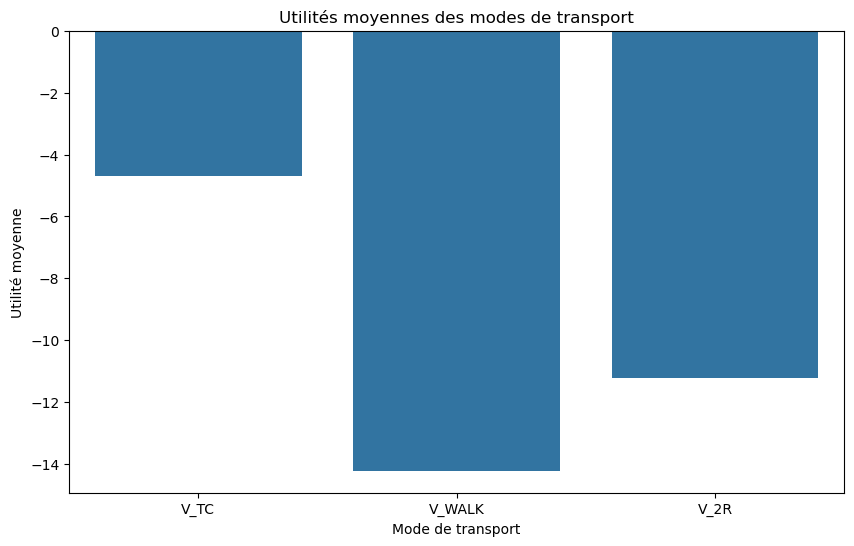

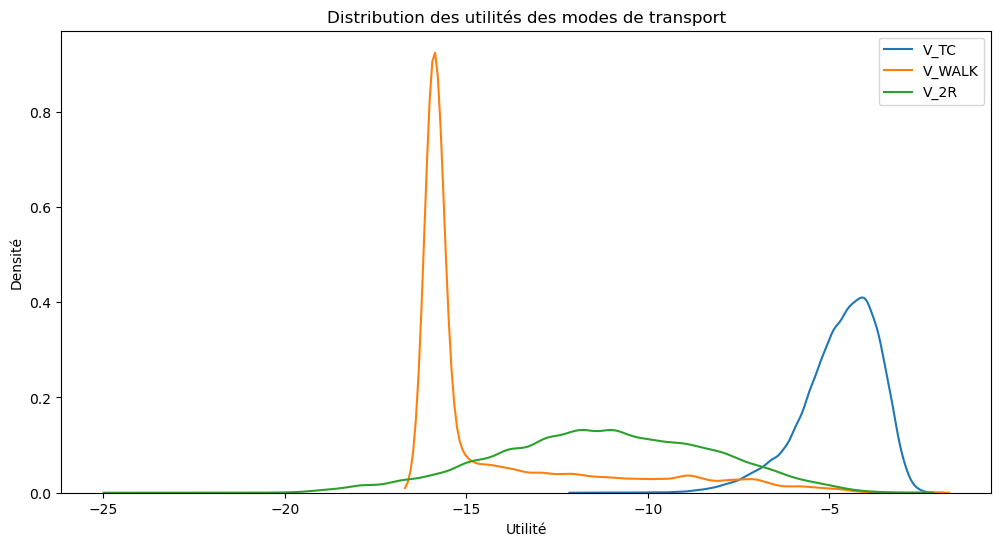

In [31]:
# Charger les paramètres
loaded_parameters = LoadParameters(func=level0, file_name='Level0_UNCONSTRAINT_celib')

# Préparer les données pour le modèle
prepared_data = prepare_data_level0_mono(df, year=2015)

# Calculer les utilités pour chaque observation
V_TC, V_WALK, V_2R = level0(loaded_parameters, prepared_data, all_sample=True)

# Ajouter les utilités au DataFrame
df['V_TC'] = V_TC.detach().numpy()  # Convertir les tenseurs en tableaux numpy si nécessaire
df['V_WALK'] = V_WALK.detach().numpy()
df['V_2R'] = V_2R.detach().numpy()

# Afficher les premières lignes du DataFrame pour vérifier
print(df[['V_TC', 'V_WALK', 'V_2R']].head())

# Calculer les statistiques descriptives
print(df[['V_TC', 'V_WALK', 'V_2R']].describe())

# Visualiser les résultats
# Exemple de graphique à barres des utilités moyennes
mean_utilities = df[['V_TC', 'V_WALK', 'V_2R']].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_utilities.index, y=mean_utilities.values)
plt.title('Utilités moyennes des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Utilité moyenne')
plt.show()

# Exemple de graphique de distribution
plt.figure(figsize=(12, 6))
for column in ['V_TC', 'V_WALK', 'V_2R']:
    sns.kdeplot(df[column], label=column)
plt.title('Distribution des utilités des modes de transport')
plt.xlabel('Utilité')
plt.ylabel('Densité')
plt.legend()
plt.show()

# Sauvegarder les résultats dans un fichier CSV
df.to_csv('utilities_results.csv', index=False)

In [32]:
import pandas as pd

# Charger les paramètres
loaded_parameters = LoadParameters(func=level0, file_name='Level0_UNCONSTRAINT_celib')

# Préparer les données pour le modèle
prepared_data = prepare_data_level0_mono(df, year=year)

# Calculer les utilités pour chaque observation
V_TC, V_WALK, V_2R = level0(loaded_parameters, prepared_data, all_sample=True)

# Créer un nouveau DataFrame pour les utilités et inclure la distance
df_utilities = pd.DataFrame({
    'V_TC_mono': V_TC.detach().numpy(),
    'V_WALK_mono': V_WALK.detach().numpy(),
    'V_2R_mono': V_2R.detach().numpy(),
    'DISTANCE_mono': df['DISTANCE'],  # Renommer DISTANCE en DISTANCE_mono
    'GENDER': df['GENDER']  # Inclure la variable GENDER_mono
})

# Sauvegarder les résultats dans un fichier Parquet
df_utilities.to_parquet('utilités.parquet', engine='pyarrow')


In [58]:
 print(df_utilities)

        V_TC_mono  V_WALK_mono  V_2R_mono  DISTANCE_mono  GENDER
0           -4.18      -15.896    -14.108         62.075       1
1          -3.557      -15.896    -18.099         62.075       0
2          -4.999      -15.896    -11.871         62.075       1
3          -3.786      -15.896    -14.082         62.075       1
4          -4.273      -15.896    -16.869         62.558       0
...           ...          ...        ...            ...     ...
136857     -3.801       -8.262    -11.999          3.251       0
136858     -5.117      -15.494    -10.182          8.832       1
136859     -5.444      -15.494    -10.113          8.832       1
136860     -5.139      -15.494    -10.227          8.832       1
136861     -5.612      -14.044     -8.237          6.957       1

[136862 rows x 5 columns]


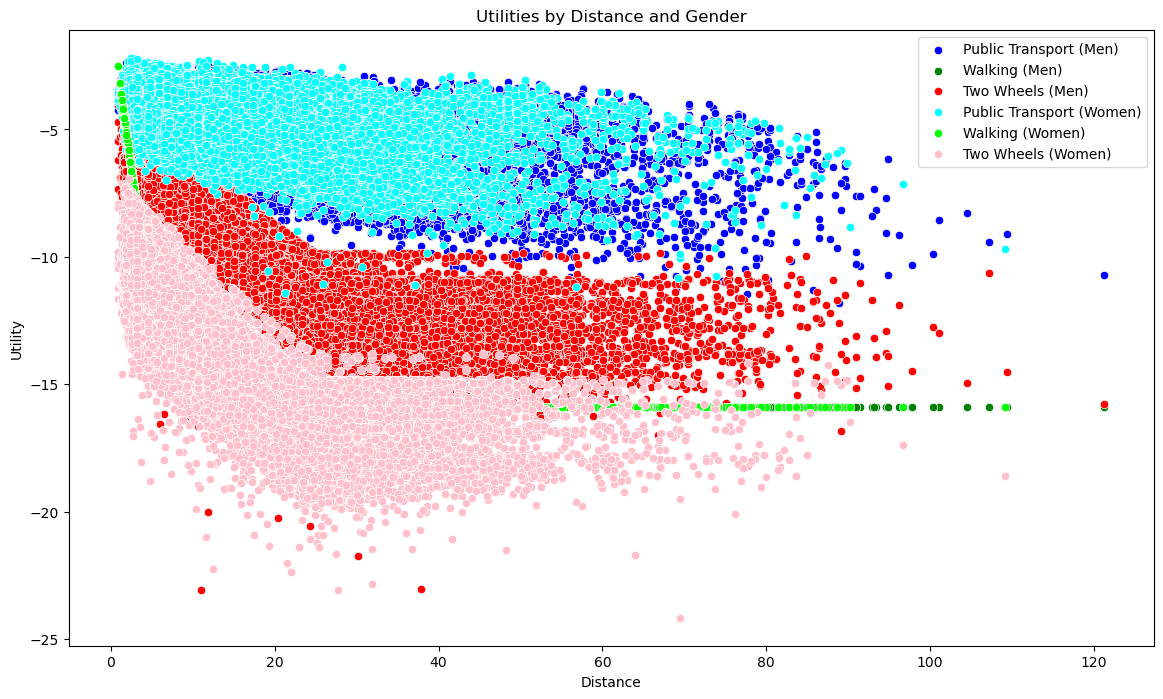

In [33]:
# Charger les données sauvegardées
df_utilities = pd.read_parquet('utilités.parquet')

# Tracer les utilités en fonction de la distance pour chaque mode de transport
plt.figure(figsize=(14, 8))

# Tracer pour les hommes (GENDER = 1)
df_men = df_utilities[df_utilities['GENDER'] == 1]
sns.scatterplot(data=df_men, x='DISTANCE_mono', y='V_TC_mono', label='Public Transport (Men)', color='blue')
sns.scatterplot(data=df_men, x='DISTANCE_mono', y='V_WALK_mono', label='Walking (Men)', color='green')
sns.scatterplot(data=df_men, x='DISTANCE_mono', y='V_2R_mono', label='Two Wheels (Men)', color='red')

# Tracer pour les femmes (GENDER_mono = 0)
df_women = df_utilities[df_utilities['GENDER'] == 0]
sns.scatterplot(data=df_women, x='DISTANCE_mono', y='V_TC_mono', label='Public Transport (Women)', color='cyan')
sns.scatterplot(data=df_women, x='DISTANCE_mono', y='V_WALK_mono', label='Walking (Women)', color='lime')
sns.scatterplot(data=df_women, x='DISTANCE_mono', y='V_2R_mono', label='Two Wheels (Women)', color='pink')

plt.title('Utilities by Distance and Gender')
plt.xlabel('Distance')
plt.ylabel('Utility')
plt.legend()
plt.show()

Optimizing:   0%|          | 0/5000 [02:58<?, ?it/s]


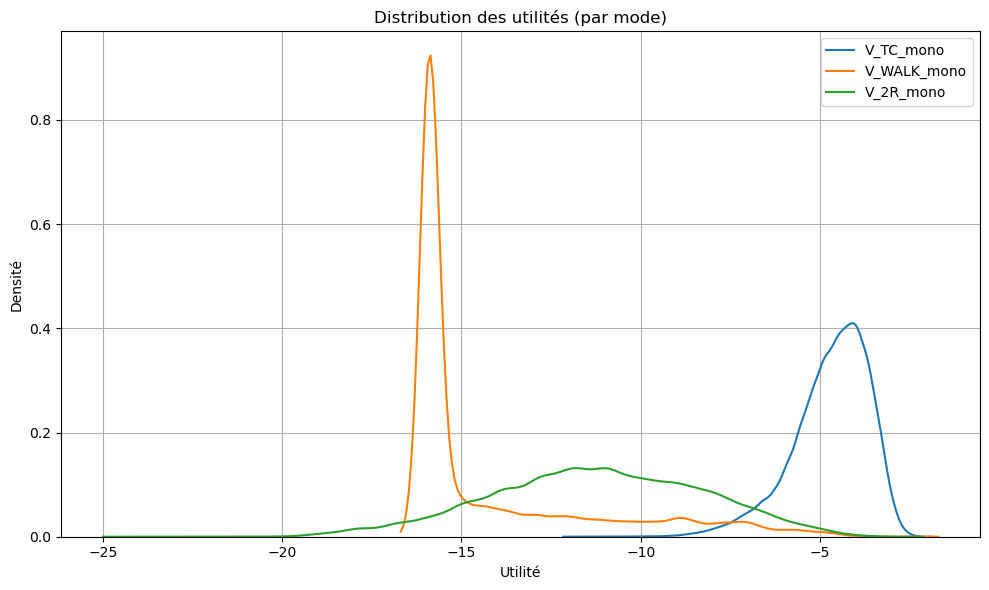

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for col in ['V_TC_mono', 'V_WALK_mono', 'V_2R_mono']:
    sns.kdeplot(df_utilities[col], label=col)

plt.title("Distribution des utilités (par mode)")
plt.xlabel("Utilité")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
